As the climate changes, predicting the weather becomes ever more important for businesses. Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of sklearn and MLflow.

You will be working with data stored in london_weather.csv, which contains the following columns:

- date - recorded date of measurement - (int)
- cloud_cover - cloud cover measurement in oktas - (float)
- sunshine - sunshine measurement in hours (hrs) - (float)
- global_radiation - irradiance measurement in Watt per square meter (W/m2) - (float)
- max_temp - maximum temperature recorded in degrees Celsius (°C) - (float)
- mean_temp - mean temperature in degrees Celsius (°C) - (float)
- min_temp - minimum temperature recorded in degrees Celsius (°C) - (float)
- precipitation - precipitation measurement in millimeters (mm) - (float)
- pressure - pressure measurement in Pascals (Pa) - (float)
- snow_depth - snow depth measurement in centimeters (cm) - (float)

In [40]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Read in the data
weather = pd.read_csv("london_weather.csv")

# Display the first few rows of the dataset
print(weather.head())

# Display column names and data types
print(weather.info())

       date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101          2.0       7.0              52.0       2.3       -4.1   
1  19790102          6.0       1.7              27.0       1.6       -2.6   
2  19790103          5.0       0.0              13.0       1.3       -2.8   
3  19790104          8.0       0.0              13.0      -0.3       -2.6   
4  19790105          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         9.0  
1      -7.5            0.0  102530.0         8.0  
2      -7.2            0.0  102050.0         4.0  
3      -6.5            0.0  100840.0         2.0  
4      -1.4            0.0  102250.0         1.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341

In [41]:
# Convert the 'date' column to datetime format
weather['date'] = pd.to_datetime(weather['date'])

# Use 'mean_temp' as the temperature column for analysis
weather['temperature'] = weather['mean_temp']

# Extract additional date-related features
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather['day'] = weather['date'].dt.day
weather['day_of_week'] = weather['date'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Display the updated DataFrame to verify changes
print(weather.head())

                           date  cloud_cover  sunshine  global_radiation  \
0 1970-01-01 00:00:00.019790101          2.0       7.0              52.0   
1 1970-01-01 00:00:00.019790102          6.0       1.7              27.0   
2 1970-01-01 00:00:00.019790103          5.0       0.0              13.0   
3 1970-01-01 00:00:00.019790104          8.0       0.0              13.0   
4 1970-01-01 00:00:00.019790105          6.0       2.0              29.0   

   max_temp  mean_temp  min_temp  precipitation  pressure  snow_depth  \
0       2.3       -4.1      -7.5            0.4  101900.0         9.0   
1       1.6       -2.6      -7.5            0.0  102530.0         8.0   
2       1.3       -2.8      -7.2            0.0  102050.0         4.0   
3      -0.3       -2.6      -6.5            0.0  100840.0         2.0   
4       5.6       -0.8      -1.4            0.0  102250.0         1.0   

   temperature  year  month  day  day_of_week  
0         -4.1  1970      1    1            3  
1       

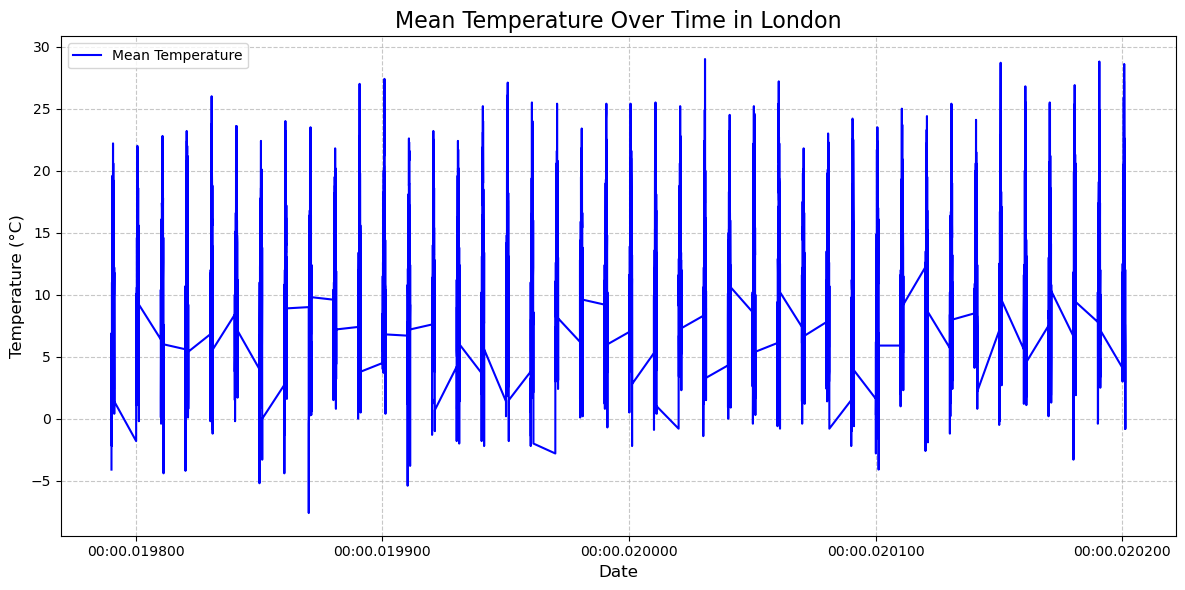

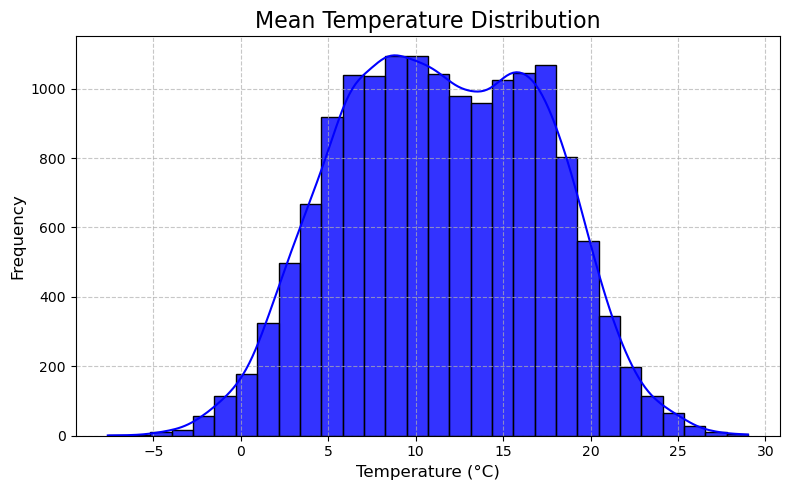

In [42]:
# Ensure the 'temperature' column is derived from 'mean_temp' (if not already used consistently)
if 'temperature' not in weather.columns:
    weather['temperature'] = weather['mean_temp']

# Drop rows with missing values in 'temperature' to avoid issues during visualization
weather = weather.dropna(subset=['temperature'])

# Visualize the temperature (mean_temp) over time
plt.figure(figsize=(12, 6))
plt.plot(weather['date'], weather['temperature'], label='Mean Temperature', color='blue')
plt.title('Mean Temperature Over Time in London', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()  # Ensure proper spacing
plt.show()

# Histogram of temperature distribution
plt.figure(figsize=(8, 5))
sns.histplot(weather['temperature'], kde=True, bins=30, color='blue', alpha=0.8)
plt.title('Mean Temperature Distribution', fontsize=16)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [43]:
# Drop rows with missing target values
weather = weather.dropna(subset=['mean_temp'])

# Select relevant features for predicting 'mean_temp'
features = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'min_temp', 
            'precipitation', 'pressure', 'snow_depth']
target = 'mean_temp'

X = weather[features]
y = weather[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline for preprocessing
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('scaler', StandardScaler())                 # Normalize the features
])

# Apply the pipeline to the training and testing data
X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
X_test_transformed = preprocessing_pipeline.transform(X_test)

# Convert the transformed data back to DataFrame with the correct feature names
X_train = pd.DataFrame(X_train_transformed, columns=features, index=X_train.index)
X_test = pd.DataFrame(X_test_transformed, columns=features, index=X_test.index)

# Ensure the transformed data retains feature names
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)

Training features shape: (12244, 8)
Testing features shape: (3061, 8)


In [44]:
# Define models and hyperparameters
models = {
    "LinearRegression": {
        "model": LinearRegression(),
        "params": {}
    },
    "DecisionTreeRegressor": {
        "model": DecisionTreeRegressor(),
        "params": {
            "max_depth": [5, 10, 15],
            "min_samples_split": [2, 5, 10]
        }
    },
    "RandomForestRegressor": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [5, 10, 15]
        }
    }
}

# Start MLflow experiment
mlflow.set_experiment("Temperature Prediction")

# Loop through models and hyperparameters
for model_name, model_info in models.items():
    model = model_info["model"]
    param_grid = model_info["params"]

    # If there are hyperparameters to tune
    if param_grid:
        grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        # For models without hyperparameters
        model.fit(X_train, y_train)
        best_model = model
        best_params = {}

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Log model and metrics to MLflow
    with mlflow.start_run(run_name=model_name):
        mlflow.log_params(best_params)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)

        # Create an input example using the first row of the test set
        input_example = X_test.iloc[:1]

        # Log the model with an input example
        mlflow.sklearn.log_model(best_model, model_name, input_example=input_example)

        print(f"Model: {model_name}")
        print(f"Best Params: {best_params}")
        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")

Model: LinearRegression
Best Params: {}
MSE: 0.7633476541201912
RMSE: 0.8736976903484358
Model: DecisionTreeRegressor
Best Params: {'max_depth': 10, 'min_samples_split': 10}
MSE: 1.0112076030367452
RMSE: 1.005588187598057
Model: RandomForestRegressor
Best Params: {'max_depth': 10, 'n_estimators': 200}
MSE: 0.72167528077134
RMSE: 0.8495147325216555


In [46]:
# Search for all runs in the default experiment
experiment_id = mlflow.get_experiment_by_name("Default").experiment_id
experiment_results = mlflow.search_runs(experiment_ids=[experiment_id])

# Display the results
print(experiment_results)

Empty DataFrame
Columns: [run_id, experiment_id, status, artifact_uri, start_time, end_time]
Index: []
